In [192]:
# %load ../src/claude_run.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from typing import Tuple, List, Dict, Optional
import seaborn as sns

def generate_population(pop_size=100_000, 
                       baseline_prevalence=0.05,
                       top_k_factor=2,
                       top_k=250,
                       noise_level=0.03):
    """
    Create a synthetic population with a 'true_risk' of stroke
    and some model score 'pred_score'. We'll adjust correlation
    so that the top 250 have ~12% real risk on average.
    
    Parameters:
    -----------
    pop_size : int
        Size of the population to generate
    baseline_prevalence : float
        Overall average stroke risk in the population
    top_k_factor : int
       e.g. 2x the baseline
    top_k : int
        Number of top-risk patients to select 
    noise_level : float
        Initial standard deviation of the noise to add to true_risk
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with patient_id, true_risk, and pred_score columns
    """
    print(f"Generating population of {pop_size} patients...")
    
    # Create dataframe with patient IDs and true risk
    df = pd.DataFrame({
        "patient_id": range(pop_size),
        # Basic random risk around the baseline prevalence
        "true_risk": np.random.beta(a=2, b=38, size=pop_size)  # mean ~5%
    })

    annual_risk = baseline_prevalence
    monthly_prevalence = 1 - (1 - annual_risk)**(1/12)

    # Scale to get exact baseline prevalence
    df["true_risk"] = df["true_risk"] * (monthly_prevalence / df["true_risk"].mean())
    
    # 3. Convert factor -> target PPV
    target_ppv = monthly_prevalence * top_k_factor

    # Create predicted score with noise
    calibrate_model_score(df, top_k=250, target_ppv=target_ppv, 
                          initial_noise=noise_level)
    
    print(f"Population generated. Overall risk: {df['true_risk'].mean():.4f}")
    print(f"Top 250 average true risk: {df['true_risk'].nlargest(top_k).mean():.4f}")
    
    return df

def calibrate_model_score(df, top_k=250, target_ppv=0.12, initial_noise=0.03, max_attempts=10):
    """
    Calibrate the model's predicted score to achieve a target positive predictive value 
    for the top k predictions.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with true_risk column
    top_k : int
        Number of top-risk patients to select
    target_ppv : float
        Target average risk for the top-k patients
    initial_noise : float
        Starting noise level
    max_attempts : int
        Maximum calibration attempts
    """
    noise_level = initial_noise
    
    for attempt in range(max_attempts):
        # Generate predicted score with current noise level
        noise = np.random.normal(0, noise_level, size=len(df))
        df["pred_score"] = df["true_risk"] + noise
        
        # Clip to valid probability range
        raw_score = df["true_risk"] + noise
        
        df["pred_score"] = np.clip(df["pred_score"], 0, 1)
        
        # Measure current PPV
        top_k_indices = df["pred_score"].nlargest(top_k).index
        current_ppv = df.loc[top_k_indices, "true_risk"].mean()
        
        # Check if we're close enough to target
        if abs(current_ppv - target_ppv) / target_ppv < 0.05:
            print(f"Model calibrated after {attempt+1} attempts. Top-{top_k} PPV: {current_ppv:.4f}")
            return
        
        # Adjust noise level based on current PPV
        if current_ppv < target_ppv:
            # Reduce noise to make model more accurate
            noise_level *= 0.8
        else:
            # Increase noise to make model less accurate
            noise_level *= 1.2
    
    print(f"Calibration stopped after {max_attempts} attempts. Final PPV: {current_ppv:.4f}")

def simulate_monthly_intervention(df, 
                                  intervention_efficacy=0.20, 
                                  top_k=250, 
                                  months=12):
    """
    12 monthly cycles:
      - Pick top 250 who haven't been treated yet.
      - Mark them as treated -> reduce stroke risk.
      - Exclude them from next month.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Population dataframe with true_risk and pred_score
    intervention_efficacy : float
        Relative reduction in stroke risk for treated patients
    top_k : int
        Number of highest-risk patients to select each month
    months : int
        Number of months to simulate
        
    Returns:
    --------
    tuple
        (DataFrame with simulation results, list of monthly thresholds)
    """
    df = df.copy()
    df["treated"] = False
    df["treatment_month"] = np.nan
    df["final_outcome"] = 0  # Will fill in whether they had a stroke
    
    # Track thresholds for each month
    monthly_thresholds = []

    for m in range(months):
        # Exclude the already treated patients from selection
        untreated = df.loc[~df["treated"]]
        
        if len(untreated) < top_k:
            print(f"Month {m}: Only {len(untreated)} untreated patients remain (< {top_k})")
            # Still run selection with all remaining patients
            top_k_actual = len(untreated)
        else:
            top_k_actual = top_k
        
        if len(untreated) == 0:
            print(f"Month {m}: No untreated patients remain. Stopping monthly selection.")
            break
            
        # Sort untreated patients by predicted score descending
        selected = untreated.nlargest(top_k_actual, "pred_score").index
        
        # Record the threshold for this month (minimum pred_score among selected)
        threshold = df.loc[selected, "pred_score"].min()
        monthly_thresholds.append({"month": m, "threshold": threshold, "n_selected": len(selected)})
        
        # Mark selected patients as treated in this month
        df.loc[selected, "treated"] = True
        df.loc[selected, "treatment_month"] = m
    
    print(f"Monthly selection completed. Total treated: {df['treated'].sum()}")
    
    # Now simulate stroke outcomes
    # If treated, stroke risk is (1 - efficacy) * true_risk
    treated_idx = df["treated"]
    df.loc[treated_idx, "final_outcome"] = (
        np.random.binomial(n=1, 
                           p=(df.loc[treated_idx, "true_risk"] * (1 - intervention_efficacy)))
    )
    # Untreated patients use original risk
    untreated_idx = ~treated_idx
    df.loc[untreated_idx, "final_outcome"] = (
        np.random.binomial(n=1, 
                           p=(df.loc[untreated_idx, "true_risk"]))
    )
    
    # Report outcome summary
    n_treated = df["treated"].sum()
    n_untreated = len(df) - n_treated
    treated_event_rate = df.loc[treated_idx, "final_outcome"].mean() if n_treated > 0 else 0
    untreated_event_rate = df.loc[untreated_idx, "final_outcome"].mean() if n_untreated > 0 else 0
    
    print(f"Outcome simulation completed:")
    print(f"  Treated patients: {n_treated}, Event rate: {treated_event_rate:.4f}")
    print(f"  Untreated patients: {n_untreated}, Event rate: {untreated_event_rate:.4f}")
    
    return df, monthly_thresholds

def run_rd_analysis(df, thresholds, month=-1, bandwidth=0.02):
    """
    Run regression discontinuity analysis for a specific month's threshold.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Population dataframe with simulation results
    thresholds : list
        List of dictionaries with monthly threshold information
    month : int
        Month to analyze (-1 for last month with valid threshold)
    bandwidth : float
        Bandwidth around threshold for local regression
        
    Returns:
    --------
    tuple
        (DataFrame subset used for analysis, fitted model, RD results dictionary)
    """
    # Default to last month with a valid threshold
    if month == -1:
        month = thresholds[-1]["month"]
    
    # Get threshold for specified month
    threshold_info = next((t for t in thresholds if t["month"] == month), None)
    if not threshold_info:
        raise ValueError(f"No threshold information found for month {month}")
    
    cutoff = threshold_info["threshold"]
    print(f"Running RD analysis for month {month} with threshold {cutoff:.4f}")
    
    # Calculate distance from threshold
    df["dist"] = df["pred_score"] - cutoff
    
    # Define RD treatment indicator
    # For classic RD: treatment is whether pred_score >= cutoff
    df["rd_treat"] = (df["pred_score"] >= cutoff).astype(int)
    
    # Limit to bandwidth around the cutoff
    sub = df.loc[df["dist"].abs() <= bandwidth].copy()
    print(f"Using {len(sub)} observations within bandwidth {bandwidth}")
    
    # Run RD models with different specifications
    results = {}
    
    # 1. Simple model without interaction
    model1 = smf.ols("final_outcome ~ rd_treat + dist", data=sub).fit()
    results["simple"] = {
        "model": model1,
        "coef": model1.params["rd_treat"],
        "se": model1.bse["rd_treat"],
        "pvalue": model1.pvalues["rd_treat"],
        "conf_int": model1.conf_int().loc["rd_treat"].tolist()
    }
    
    # 2. Model with interaction
    model2 = smf.ols("final_outcome ~ rd_treat + dist + rd_treat:dist", data=sub).fit()
    results["interaction"] = {
        "model": model2,
        "coef": model2.params["rd_treat"],
        "se": model2.bse["rd_treat"],
        "pvalue": model2.pvalues["rd_treat"],
        "conf_int": model2.conf_int().loc["rd_treat"].tolist()
    }
    
    # Print summary of results
    print("\nRD Analysis Results:")
    print(f"Simple model: Effect={results['simple']['coef']:.6f}, p={results['simple']['pvalue']:.4f}")
    print(f"Interaction model: Effect={results['interaction']['coef']:.6f}, p={results['interaction']['pvalue']:.4f}")
    
    return sub, model2, results

def plot_rd_results(sub_df, rd_results, save_path=None):
    """
    Create visualization of RD analysis results.
    
    Parameters:
    -----------
    sub_df : pandas.DataFrame
        Dataframe subset used for RD analysis
    rd_results : dict
        Dictionary with RD analysis results
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Create binned means for visualization
    n_bins = 15
    bin_width = (sub_df["dist"].max() - sub_df["dist"].min()) / n_bins
    
    bins = []
    for i in range(n_bins):
        bin_min = sub_df["dist"].min() + i * bin_width
        bin_max = bin_min + bin_width
        
        bin_data = sub_df[(sub_df["dist"] >= bin_min) & (sub_df["dist"] < bin_max)]
        if len(bin_data) > 0:
            bins.append({
                "bin_center": (bin_min + bin_max) / 2,
                "mean_outcome": bin_data["final_outcome"].mean(),
                "count": len(bin_data)
            })
    
    bin_df = pd.DataFrame(bins)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot binned means
    ax.scatter(bin_df["bin_center"], bin_df["mean_outcome"], 
               s=bin_df["count"], alpha=0.6, label="Binned means")
    
    # Plot the fitted lines from the interaction model
    model = rd_results["interaction"]["model"]
    
    # Create prediction data
    x_range_left = np.linspace(sub_df["dist"].min(), 0, 100)
    x_range_right = np.linspace(0, sub_df["dist"].max(), 100)
    
    # Predict for left side of threshold (untreated)
    y_left = model.params["Intercept"] + model.params["dist"] * x_range_left
    
    # Predict for right side (treated)
    y_right = (model.params["Intercept"] + model.params["rd_treat"] + 
               (model.params["dist"] + model.params["rd_treat:dist"]) * x_range_right)
    
    # Plot fitted lines
    ax.plot(x_range_left, y_left, 'b-', linewidth=2, label="Control")
    ax.plot(x_range_right, y_right, 'r-', linewidth=2, label="Treatment")
    
    # Add vertical line at threshold
    ax.axvline(x=0, color='k', linestyle='--', label="Threshold")
    
    # Add labels and title
    coef = rd_results["interaction"]["coef"]
    pval = rd_results["interaction"]["pvalue"]
    ax.set_xlabel("Distance from threshold")
    ax.set_ylabel("Probability of stroke")
    ax.set_title(f"Regression Discontinuity Plot\nEffect estimate: {coef:.6f} (p={pval:.4f})")
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    return fig

def run_simulation_rd(pop_size=100_000, 
                      baseline_prevalence=0.05,
                      top_k_factor=2,
                      intervention_efficacy=0.30,
                      top_k=250, 
                      months=12,
                      bandwidth=0.02,
                      random_seed=None):
    """
    1) Generate synthetic data
    2) Run the monthly selection & intervention
    3) Perform RD analysis 
    4) Create visualization
    
    Parameters:
    -----------
    pop_size : int
        Size of the synthetic population
    baseline_prevalence : float
        Overall stroke risk in the population
    top_k_factor : int 
         e.g. 2x the baseline
    intervention_efficacy : float
        Relative reduction in stroke risk for treated patients
    top_k : int
        Number of highest-risk patients to select each month
    months : int
        Number of months to simulate
    bandwidth : float
        Bandwidth for RD analysis
    random_seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    dict
        Dictionary with simulation results and analysis objects
    """
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    print("\n" + "="*50)
    print("STARTING STROKE RISK INTERVENTION SIMULATION")
    print("="*50)
    
    # 1. Generate synthetic population
    df = generate_population(pop_size=pop_size,
                            baseline_prevalence=baseline_prevalence,
                            top_k=top_k,
                            top_k_factor=top_k_factor)
    
    # 2. Run monthly intervention simulation
    df, monthly_thresholds = simulate_monthly_intervention(
        df, 
        intervention_efficacy=intervention_efficacy,
        top_k=top_k,
        months=months
    )
    
    # 3. Run RD analysis
    try:
        sub_df, rd_model, rd_results = run_rd_analysis(
            df, 
            monthly_thresholds,
            month=-1,  # Last month
            bandwidth=bandwidth
        )
        
        # 4. Create visualization
        rd_plot = plot_rd_results(sub_df, rd_results)
        
        # Naive estimate of treatment effect (simple difference in means)
        treated_mean = df[df["treated"]]["final_outcome"].mean()
        untreated_mean = df[~df["treated"]]["final_outcome"].mean()
        naive_effect = treated_mean - untreated_mean
        
        annual_risk = baseline_prevalence
        monthly_prevalence = 1 - (1 - annual_risk)**(1/12) 
        target_ppv = monthly_prevalence * top_k_factor

        print("\nSummary of Results:")
        print(f"Naive difference in means: {naive_effect:.6f}")
        print(f"RD estimate (at threshold): {rd_results['interaction']['coef']:.6f}")
        expected_effect = intervention_efficacy * target_ppv
        print(f"Expected effect (intervention_efficacy × risk at threshold): {-expected_effect:.6f}")
        
        # Prepare results dictionary
        results = {
            "population_df": df,
            "monthly_thresholds": monthly_thresholds,
            "rd_subset": sub_df,
            "rd_model": rd_model,
            "rd_results": rd_results,
            "rd_plot": rd_plot,
            "summary": {
                "pop_size": pop_size,
                "total_treated": df["treated"].sum(),
                "treated_event_rate": treated_mean,
                "untreated_event_rate": untreated_mean,
                "naive_effect": naive_effect,
                "rd_effect": rd_results["interaction"]["coef"],
                "expected_effect": -expected_effect
            }
        }
        
    except Exception as e:
        print(f"Error in RD analysis: {e}")
        results = {
            "population_df": df,
            "monthly_thresholds": monthly_thresholds,
            "error": str(e)
        }
    
    print("\n" + "="*50)
    print("SIMULATION COMPLETED")
    print("="*50 + "\n")
    
    return results

# if __name__ == "__main__":
#     # Example: single run with fixed random seed for reproducibility
#     results = run_simulation_rd(
#         pop_size=50_000,
#         baseline_prevalence=0.05,
#         top_k_factor=0.12,
#         intervention_efficacy=0.6,
#         top_k=250,
#         months=12,
#         bandwidth=0.02,
#         random_seed=32
#     )
    
#     # Display the RD plot
#     plt.show()


STARTING STROKE RISK INTERVENTION SIMULATION
Generating population of 50000 patients...
Calibration stopped after 10 attempts. Final PPV: 0.0135
Population generated. Overall risk: 0.0043
Top 250 average true risk: 0.0170
Monthly selection completed. Total treated: 12000
Outcome simulation completed:
  Treated patients: 12000, Event rate: 0.0041
  Untreated patients: 38000, Event rate: 0.0035
Running RD analysis for month 47 with threshold 0.0076
Using 49671 observations within bandwidth 0.01

RD Analysis Results:
Simple model: Effect=-0.000962, p=0.3697
Interaction model: Effect=-0.001181, p=0.2954

Summary of Results:
Naive difference in means: 0.000557
RD estimate (at threshold): -0.001181
Expected effect (intervention_efficacy × risk at threshold): -0.006398

SIMULATION COMPLETED



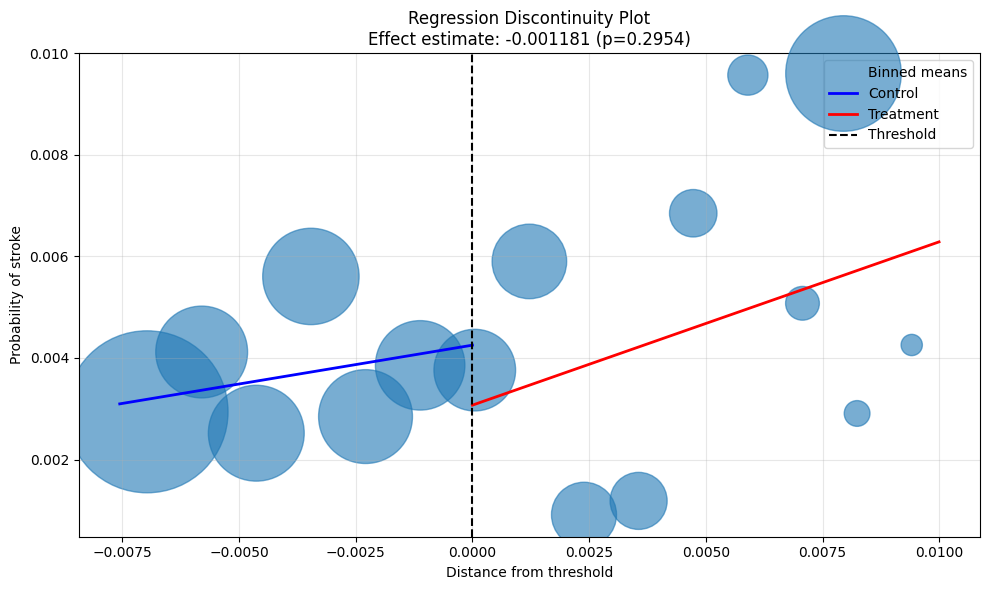

In [193]:
results = run_simulation_rd(
        pop_size=50_000,
        baseline_prevalence=0.05,
        top_k_factor=5,
        intervention_efficacy=0.3,
        top_k=250,
        months=48,
        bandwidth=0.01,
        random_seed=45
    )

In [52]:
df_pop = generate_population(pop_size=100_000, 
                       baseline_prevalence=0.05,
                       top_k_factor=2,
                       top_k=250,
                       noise_level=0.03)

Generating population of 100000 patients...
Model calibrated after 6 attempts. Top-250 PPV: 0.0081
Population generated. Overall risk: 0.0043
Top 250 average true risk: 0.0182


In [50]:
df, monthly_thresholds = simulate_monthly_intervention(
        df, 
        intervention_efficacy=0.20,
        top_k=250,
        months=12
    )

Monthly selection completed. Total treated: 3000
Outcome simulation completed:
  Treated patients: 3000, Event rate: 0.0050
  Untreated patients: 97000, Event rate: 0.0042


In [57]:
df[df['treated']==True]

,patient_id,true_risk,pred_score,treated,treatment_month,final_outcome
26,26,0.004182,0.025353,True,8.0,0
73,73,0.007908,0.027909,True,4.0,0
74,74,0.015719,0.037486,True,0.0,0
77,77,0.007707,0.024422,True,10.0,0
92,92,0.011640,0.027333,True,5.0,0
...,...,...,...,...,...,...
99892,99892,0.013197,0.031632,True,1.0,0
99913,99913,0.002577,0.028954,True,3.0,0
99935,99935,0.003848,0.026651,True,6.0,0
99945,99945,0.005200,0.026485,True,6.0,0


In [78]:
df_pop_cp = df_pop.copy()
df_pop_cp["treated"] = False
df_pop_cp["treatment_month"] = np.nan
df_pop_cp["final_outcome"] = 0  # Will fill in whether they had a stroke

In [79]:
untreated = df_pop_cp.loc[~df_pop_cp["treated"]]

In [80]:
 monthly_thresholds = []

In [81]:
selected = untreated.nlargest(250, "pred_score").index

In [82]:
selected

Index([43927, 95747, 89598, 71935, 92091, 81931, 35177, 98779, 60641, 99757,
       ...
       99641, 69747, 38369, 58732, 79534, 10233, 41553, 61720, 32258, 17686],
      dtype='int64', length=250)

In [83]:
# Record the threshold for this month (minimum pred_score among selected)
threshold = df_pop_cp.loc[selected, "pred_score"].min()
monthly_thresholds.append({"month": 1, "threshold": threshold, "n_selected": len(selected)})
        

In [126]:
mike = df_pop_cp.loc[selected]

In [134]:
mike.tail(20)

,patient_id,true_risk,pred_score,treated,treatment_month,final_outcome
52855,52855,0.005456,0.033491,True,1.0,0
67313,67313,0.009776,0.033405,True,1.0,0
66322,66322,0.005289,0.033400,True,1.0,0
21352,21352,0.009978,0.033395,True,1.0,0
92830,92830,0.010825,0.033393,True,1.0,0
62254,62254,0.007110,0.033383,True,1.0,0
29734,29734,0.003443,0.033378,True,1.0,0
33713,33713,0.003206,0.033364,True,1.0,0
31193,31193,0.005994,0.033342,True,1.0,0
40488,40488,0.009774,0.033341,True,1.0,0


In [84]:
monthly_thresholds

[{'month': 1, 'threshold': 0.033232798195645105, 'n_selected': 250}]

<Axes: >

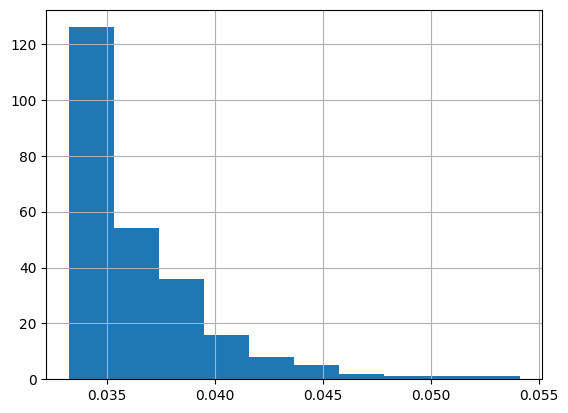

In [131]:
df_pop_cp.loc[selected, "pred_score"].hist()

In [88]:
 # Mark selected patients as treated in this month
df_pop_cp.loc[selected, "treated"] = True
df_pop_cp.loc[selected, "treatment_month"] = 1

In [89]:
treated_idx = df_pop_cp["treated"]

In [94]:
(np.random.binomial(n=1,p=(df_pop_cp.loc[treated_idx, "true_risk"] * (1 - intervention_efficacy))))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
1 - intervention_efficacy

0.8

In [99]:
df_pop_cp.loc[treated_idx, "true_risk"]*.8

600      0.003252
1007     0.007229
2293     0.003304
2307     0.004841
2788     0.008325
           ...   
98718    0.002131
98779    0.012704
99641    0.000402
99757    0.018881
99971    0.007880
Name: true_risk, Length: 250, dtype: float64